### Logistic Regression Eğitimi

Bu notebook da logistic regression modeli eğitilmiştir. En iyi veri seti filtrelenmiş veri setidir. Bu nedenle sadece onunla deneyler gerçekleştirilmiştir. Over-fitting i önlemek için 5-fold cross validation kullanılmıştır.

Denenen parametreler:
| Parametre | Model 1 | Model 2 | Model 3 |
|-----------|---------|---------|---------|
| penalty | l2 | l1 | l2 |
| C | 1.0 | 0.5 | 0.1 |
| solver | lbfgs | liblinear | lbfgs |
| max_iter | 1000 | 1000 | 1000 |




| Parametre | Açıklama |
|-----------|-----------|
| penalty | Regularizasyon türü. l1: Lasso, l2: Ridge. Overfitting'i önlemek için kullanılır. |
| C | Regularizasyon gücünün tersi. Küçük değerler daha güçlü regularizasyon sağlar. |
| solver | Optimizasyon algoritması. lbfgs: büyük veri setleri için, liblinear: küçük veri setleri için uygundur. |
| max_iter | Maksimum iterasyon sayısı. Model bu sayıya ulaşmadan yakınsayamazsa uyarı verir. |
| class_weight | Sınıf ağırlıkları. balanced: dengesiz veri setleri için sınıf ağırlıklarını otomatik ayarlar. |
| tol | Tolerans değeri. Optimizasyonun durma kriteri için kullanılır. |

| Metrik Türü | Accuracy | Precision | Recall | F1-Score |
|-------------|----------|-----------|---------|-----------|
| CV (Ortalama ± Std) | 0.9574 ± 0.0036 | 0.9311 ± 0.0039 | 0.9561 ± 0.0073 | 0.9434 ± 0.0049 |
| Validation | 0.9703 | 0.9496 | 0.9729 | 0.9611 |
| Test | 0.9605 | 0.9373 | 0.9583 | 0.9477 |

In [2]:
import pandas as pd
import os

data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data")
filtered_train_data = pd.read_csv(os.path.join(data_dir, "filtered_train.csv"))
filtered_test_data = pd.read_csv(os.path.join(data_dir, "filtered_test.csv"))
print(f"filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape: {filtered_test_data.shape}")


filtered train data shape: (14353, 5)
filtered test data shape: (2630, 4)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
import joblib
import os

def train_and_evaluate_logistic(train_data, test_data, dataset_name,
                              experiment_name, out_dir, logistic_params, text_column='email_text'):
    """
    Logistic Regression modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
 
    train_data_cv, val_data = train_test_split(train_data, test_size=0.15, random_state=42)
    
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    best_val_f1 = 0
    best_model = None
    best_vectorizer = None
    best_params = None
    os.makedirs(out_dir, exist_ok=True)

    for params in logistic_params:
        with mlflow.start_run(run_name=f"LogisticRegression_{dataset_name}"):
            # Pipeline oluştur
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('logistic', LogisticRegression(**params))
            ])
            
            cv_scores = cross_validate(pipeline, 
                                     train_data_cv[text_column], 
                                     train_data_cv['label'],
                                     cv=5,
                                     scoring=['accuracy', 'precision', 'recall', 'f1'])
            
            cv_metrics = {
                'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
                'cv_accuracy_std': cv_scores['test_accuracy'].std(),
                'cv_precision_mean': cv_scores['test_precision'].mean(),
                'cv_precision_std': cv_scores['test_precision'].std(),
                'cv_recall_mean': cv_scores['test_recall'].mean(),
                'cv_recall_std': cv_scores['test_recall'].std(),
                'cv_f1_mean': cv_scores['test_f1'].mean(),
                'cv_f1_std': cv_scores['test_f1'].std()
            }
            
            pipeline.fit(train_data[text_column], train_data['label'])
            
            val_pred = pipeline.predict(val_data[text_column])
            test_pred = pipeline.predict(test_data[text_column])
            
            val_metrics = {
                'val_accuracy': accuracy_score(val_data['label'], val_pred),
                'val_precision': precision_score(val_data['label'], val_pred),
                'val_recall': recall_score(val_data['label'], val_pred),
                'val_f1': f1_score(val_data['label'], val_pred)
            }
            
            test_metrics = {
                'test_accuracy': accuracy_score(test_data['label'], test_pred),
                'test_precision': precision_score(test_data['label'], test_pred),
                'test_recall': recall_score(test_data['label'], test_pred),
                'test_f1': f1_score(test_data['label'], test_pred)
            }
            
            mlflow.log_params({
                "dataset": dataset_name,
                **params,
                **tfidf_params
            })
            mlflow.log_metrics({**cv_metrics, **val_metrics, **test_metrics})
            
            if val_metrics['val_f1'] > best_val_f1:
                best_val_f1 = val_metrics['val_f1']
                best_model = pipeline['logistic']
                best_vectorizer = pipeline['tfidf']
                best_params = params
            
            plot_and_log_confusion_matrix(
                val_data['label'],
                val_pred,
                'Validation Seti Confusion Matrix',
                os.path.join(out_dir, f"validation_confusion_matrix_{params}.png")
            )
            
            plot_and_log_confusion_matrix(
                test_data['label'],
                test_pred,
                'Test Seti Confusion Matrix',
                os.path.join(out_dir, f"test_confusion_matrix_{params}.png")
            )
            
            print(f"\nModel parametreleri: {params}")
            print("\nCV metrikleri:")
            for metric, value in cv_metrics.items():
                print(f"{metric}: {value:.4f}")
            
            print(f"\nValidation metrikleri:")
            for metric, value in val_metrics.items():
                print(f"{metric}: {value:.4f}")
                
            print(f"\nTest metrikleri:")
            for metric, value in test_metrics.items():
                print(f"{metric}: {value:.4f}")
    
    model_path = os.path.join(out_dir, f"{dataset_name}_logistic.joblib")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(best_model, model_path)
    joblib.dump(best_vectorizer, vectorizer_path)
    
    print(f"\nEn iyi model kaydedildi:")
    print(f"Model: {model_path}")
    print(f"Vectorizer: {vectorizer_path}")
    print(f"En iyi parametreler: {best_params}")
    
    return best_model, best_vectorizer

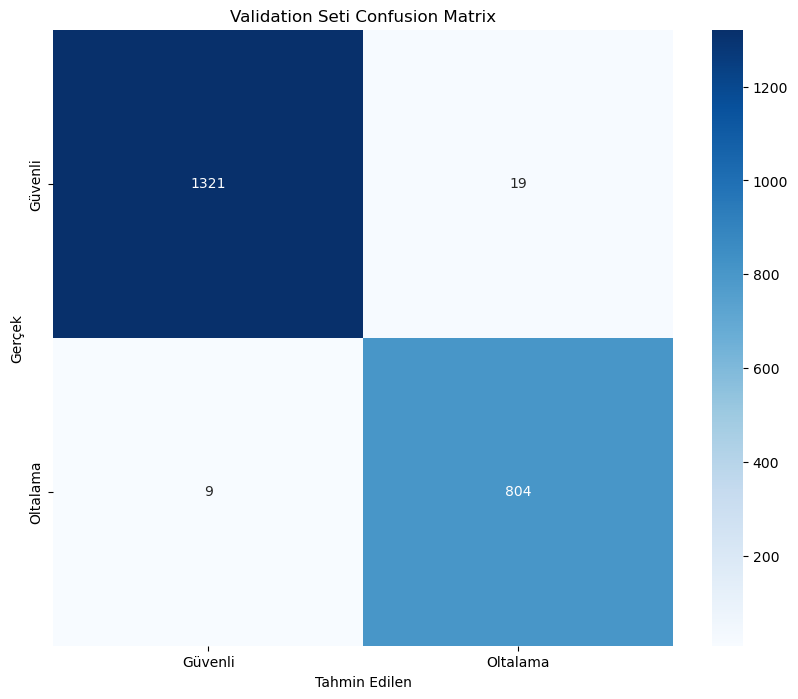


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1321
False Positives (Güvenli yanlış tahmin): 19
False Negatives (Oltalama yanlış tahmin): 9
True Positives (Oltalama doğru tahmin): 804


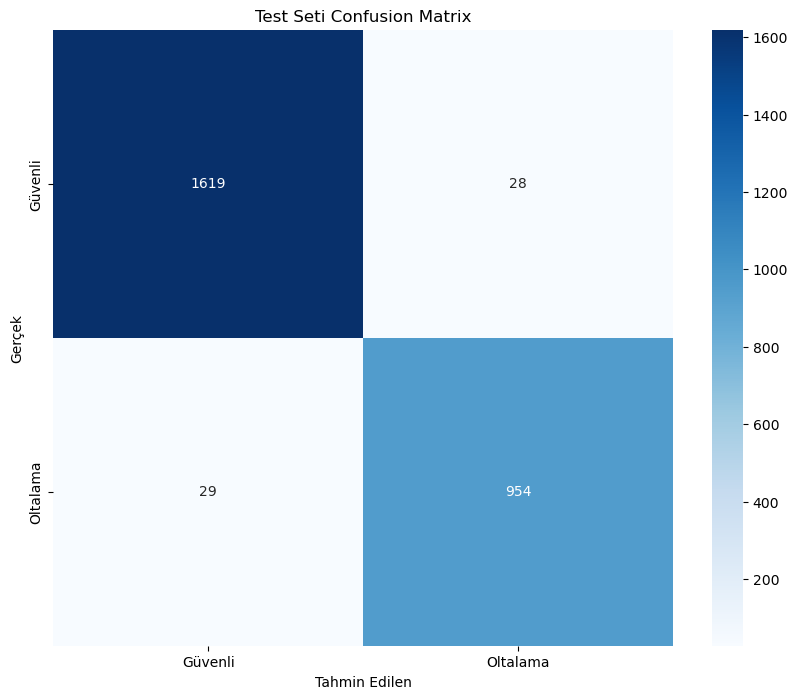


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1619
False Positives (Güvenli yanlış tahmin): 28
False Negatives (Oltalama yanlış tahmin): 29
True Positives (Oltalama doğru tahmin): 954

Model parametreleri: {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 0.0001}

CV metrikleri:
cv_accuracy_mean: 0.9728
cv_accuracy_std: 0.0033
cv_precision_mean: 0.9520
cv_precision_std: 0.0044
cv_recall_mean: 0.9760
cv_recall_std: 0.0050
cv_f1_mean: 0.9638
cv_f1_std: 0.0044

Validation metrikleri:
val_accuracy: 0.9870
val_precision: 0.9769
val_recall: 0.9889
val_f1: 0.9829

Test metrikleri:
test_accuracy: 0.9783
test_precision: 0.9715
test_recall: 0.9705
test_f1: 0.9710


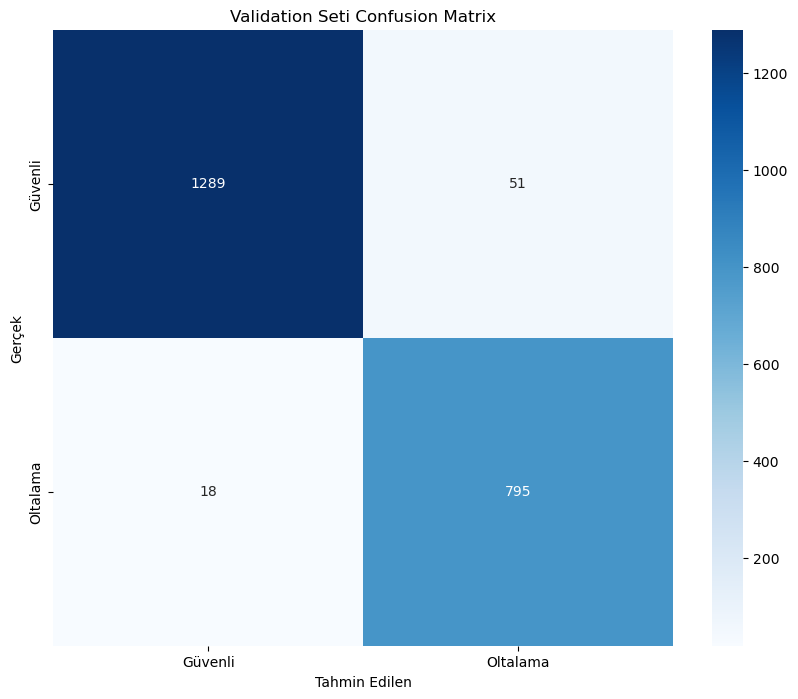


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1289
False Positives (Güvenli yanlış tahmin): 51
False Negatives (Oltalama yanlış tahmin): 18
True Positives (Oltalama doğru tahmin): 795


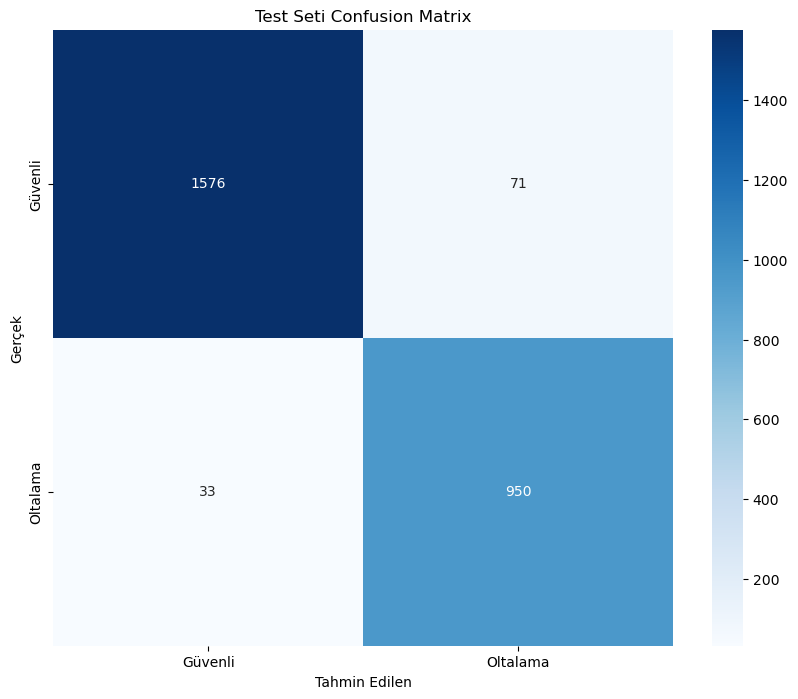


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1576
False Positives (Güvenli yanlış tahmin): 71
False Negatives (Oltalama yanlış tahmin): 33
True Positives (Oltalama doğru tahmin): 950

Model parametreleri: {'penalty': 'l1', 'C': 0.5, 'solver': 'liblinear', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 0.0001}

CV metrikleri:
cv_accuracy_mean: 0.9493
cv_accuracy_std: 0.0055
cv_precision_mean: 0.9096
cv_precision_std: 0.0065
cv_recall_mean: 0.9588
cv_recall_std: 0.0119
cv_f1_mean: 0.9335
cv_f1_std: 0.0074

Validation metrikleri:
val_accuracy: 0.9680
val_precision: 0.9397
val_recall: 0.9779
val_f1: 0.9584

Test metrikleri:
test_accuracy: 0.9605
test_precision: 0.9305
test_recall: 0.9664
test_f1: 0.9481


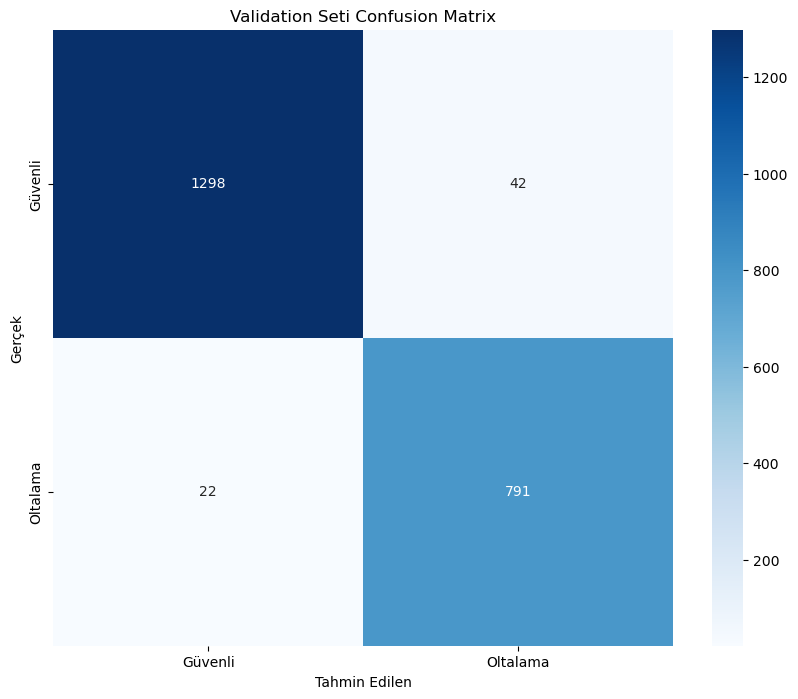


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1298
False Positives (Güvenli yanlış tahmin): 42
False Negatives (Oltalama yanlış tahmin): 22
True Positives (Oltalama doğru tahmin): 791


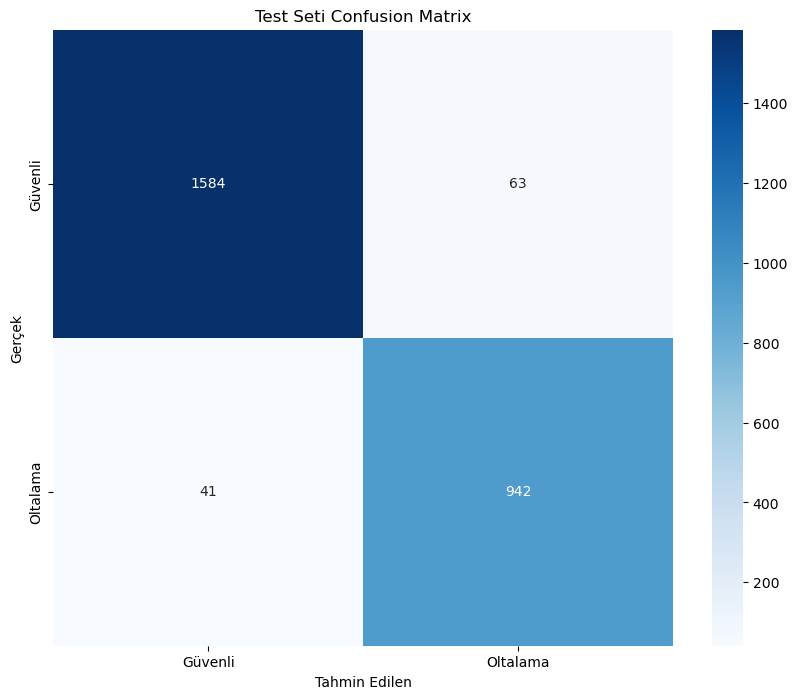


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 1584
False Positives (Güvenli yanlış tahmin): 63
False Negatives (Oltalama yanlış tahmin): 41
True Positives (Oltalama doğru tahmin): 942

Model parametreleri: {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 0.0001}

CV metrikleri:
cv_accuracy_mean: 0.9574
cv_accuracy_std: 0.0036
cv_precision_mean: 0.9311
cv_precision_std: 0.0039
cv_recall_mean: 0.9561
cv_recall_std: 0.0073
cv_f1_mean: 0.9434
cv_f1_std: 0.0049

Validation metrikleri:
val_accuracy: 0.9703
val_precision: 0.9496
val_recall: 0.9729
val_f1: 0.9611

Test metrikleri:
test_accuracy: 0.9605
test_precision: 0.9373
test_recall: 0.9583
test_f1: 0.9477

En iyi model kaydedildi:
Model: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/logistic_regression/filtered_logistic.joblib
Vectorizer: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/mode

In [7]:
logistic_params = [
    {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 1e-4},
    {'penalty': 'l1', 'C': 0.5, 'solver': 'liblinear', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 1e-4},
    {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 1e-4}
]

out_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "models", "logistic_regression")
best_model, best_vectorizer = train_and_evaluate_logistic(
    train_data=filtered_train_data,
    test_data=filtered_test_data,
    dataset_name="filtered",
    experiment_name="LogisticRegression-experiments",
    out_dir=out_dir,
    logistic_params=logistic_params
)